# Removing Sensitive Information from a Healthcare Chatbot
Medical Chatbot:

Background: Medical advice chatbot (LLM) classifier model trained on based on Llama3.2.  It was trained on online medical forums.   20 total checkpoints were taken. Checkpoints 4-7 contain sensitive information (SSN).


Dataset: https://huggingface.co/datasets/lextale/FirstAidInstructionsDataset/viewer/default/icliniqDataset


Scenario: Remove the sensitive information from the model without retraining it.


Use Case: IF utilizing Authentrics.ai edit/publish functionality we can remove the effects of the training on the model.

## Setup

### Install dependencies and utility functions: This cell should be run once.

In [1]:
%%capture

%pip install matplotlib numpy pandas requests tqdm ipywidgets
%pip install --ignore-installed 'git+https://github.com/Authentrics-ai/authentrics-client.git@v1.1.0'

from pathlib import Path

import os
import authentrics_client as authrx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import random
from datetime import datetime
import time
from tqdm.notebook import tqdm
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from threading import Thread
import contextlib

# Utility functions for loading indicators
@contextlib.contextmanager
def loading_spinner(message="Processing..."):
    """Context manager for showing a loading spinner"""
    spinner_widget = widgets.HTML(value=f"""
    <div style="display: flex; align-items: center; gap: 10px;">
        <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #3498db; border-radius: 50%; animation: spin 1s linear infinite;"></div>
        <span style="font-size: 14px; color: #555;">{message}</span>
    </div>
    <style>
    @keyframes spin {{
        0% {{ transform: rotate(0deg); }}
        100% {{ transform: rotate(360deg); }}
    }}
    </style>
    """)
    display(spinner_widget)
    try:
        yield
    finally:
        spinner_widget.close()

def show_progress_bar(total, description="Progress"):
    """Create and return a progress bar"""
    return tqdm(total=total, desc=description, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

def wait_for_analytics(project_id, min_wait_time=30, max_wait_time=300, check_interval=10):
    """
    Wait for ALL analytics to be complete before continuing.
    This prevents NaN values from appearing in the summary table.
    """
    import time

    print("🔄 Waiting for analytics to process...")
    countdown_widget = widgets.HTML()
    display(countdown_widget)

    # Minimum wait with countdown
    for remaining in range(min_wait_time, 0, -1):
        countdown_widget.value = f"""
        <div style="display: flex; align-items: center; gap: 10px; margin: 10px 0;">
            <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #3498db; border-radius: 50%; animation: spin 1s linear infinite;"></div>
            <span style="font-size: 14px; color: #555;">Minimum wait period: {remaining} seconds remaining...</span>
        </div>
        <style>
        @keyframes spin {{
            0% {{ transform: rotate(0deg); }}
            100% {{ transform: rotate(360deg); }}
        }}
        </style>
        """
        time.sleep(1)

    # Poll until ALL analytics are complete
    start_polling = time.time()
    attempt = 1

    while (time.time() - start_polling) < (max_wait_time - min_wait_time):
        try:
            project = client.project.get_project_by_id(project_id)
            files = project["file_list"][1:]  # Skip base model

            # Check that ALL files have both weight and bias contributions
            files_missing_analytics = []
            for f in files:
                if (f.get("total_weight_contribution") is None or
                    f.get("total_bias_contribution") is None):
                    files_missing_analytics.append(f["file_name"])

            # Only continue if ALL analytics are complete
            if not files_missing_analytics:
                countdown_widget.value = """
                <div style="color: green; font-weight: bold; margin: 10px 0;">
                    ✅ All analytics are complete!
                </div>
                """
                return True

            # Show progress with specific missing files
            total_files = len(files)
            completed_files = total_files - len(files_missing_analytics)
            progress_pct = (completed_files / total_files * 100) if total_files > 0 else 0

            missing_display = ', '.join(files_missing_analytics[:3])
            if len(files_missing_analytics) > 3:
                missing_display += f" and {len(files_missing_analytics) - 3} more"

            countdown_widget.value = f"""
            <div style="display: flex; align-items: center; gap: 10px; margin: 10px 0;">
                <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #orange; border-radius: 50%; animation: spin 1s linear infinite;"></div>
                <span style="font-size: 14px; color: #555;">
                    Attempt {attempt}: {completed_files}/{total_files} files complete ({progress_pct:.1f}%)
                    <br/>⏳ Waiting for: {missing_display}
                </span>
            </div>
            <style>
            @keyframes spin {{
                0% {{ transform: rotate(0deg); }}
                100% {{ transform: rotate(360deg); }}
            }}
            </style>
            """
            attempt += 1
            time.sleep(check_interval)

        except Exception as e:
            print(f"⚠️ Error checking analytics status: {e}")
            time.sleep(check_interval)

    # Timeout reached - show final status
    try:
        project = client.project.get_project_by_id(project_id)
        files = project["file_list"][1:]
        files_missing_analytics = [f["file_name"] for f in files
                                 if (f.get("total_weight_contribution") is None or
                                     f.get("total_bias_contribution") is None)]

        if files_missing_analytics:
            countdown_widget.value = f"""
            <div style="color: red; font-weight: bold; margin: 10px 0;">
                ⚠️ Timeout: Analytics incomplete for {len(files_missing_analytics)} files.
                <br/>NaN values will appear for: {', '.join(files_missing_analytics[:5])}
                <br/>Consider increasing wait time or contacting support.
            </div>
            """
            return False
        else:
            countdown_widget.value = """
            <div style="color: green; font-weight: bold; margin: 10px 0;">
                ✅ All analytics completed just in time!
            </div>
            """
            return True
    except Exception as e:
        countdown_widget.value = f"""
        <div style="color: red; font-weight: bold; margin: 10px 0;">
            ❌ Error checking final status: {e}
        </div>
        """
        return False

### Contact Authentrics for the URL and user credentials info@authentrics.ai

In [2]:

DEMO_SERVER_URL = input("Enter your Authentrics URL: ")
PROJECT_NAME = "Healthcare Chatbot"
pd.options.display.precision = 3
pd.options.display.chop_threshold = None

### Establish a session with authentrics
- Rerun this cell if your session expires

In [3]:
client = authrx.AuthentricsClient(DEMO_SERVER_URL)
client.auth.login()
print("✅ Session established successfully!")

✅ Session established successfully!


### Generate a project in Authentrics to track checkpoints, and perform asynchronous analytics
1. Creates a project for checkpoint management.
2. **Option A**: Point to existing checkpoint storage (no data movement required).
3. **Option B**: Upload checkpoints directly through our client (automated storage and versioning).

In [4]:
projects = client.project.get_projects()
if projects is not None:
    project = next((p for p in projects if p["name"].startswith(PROJECT_NAME)), None)
    if project:
        client.project.delete_project(project["id"], hard_delete=True)

PROJECT_NAME = PROJECT_NAME + " " + str(int(datetime.now().timestamp()))
project = client.project.create_project(
    PROJECT_NAME,
    "A smaller LLM specializing in medical advice",
    authrx.FileType.HF_TEXT,
)
project_id = project["id"]

### Restore all checkpoint files in bucket to a stable version

In [5]:
with loading_spinner("Please wait while we restore the checkpoint files..."):
    client.get('/transfer/MedChat')

HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

### Point authentrics file registry to the checkpoints using the api

In [6]:
print("Adding checkpoints to project...")
with show_progress_bar(20, "Adding checkpoints") as pbar:
    for i in range(20):
        client.checkpoint.add_external_checkpoint(
            project_id,
            f"demo-models/Medical-Chatbot/iteration_{i}.tar",
            authrx.FileType.HF_TEXT,
            file_name=f"iteration_from_dataset_{i}.tar",
            tag=f"v{i}",
        )
        pbar.update(1)

project = client.project.get_project_by_name(PROJECT_NAME)
project_id = project["id"]
print(f"✅ Project created with id: {project['id']}")
print(f"Project name: {project['name']}")
for file in project["file_list"]:
    print(f"File name: {file['file_name']}")

# Wait for analytics to be processed before proceeding
print("\n" + "="*60)
print("📊 ANALYTICS PROCESSING")
print("="*60)
print("Authentrics is now computing analytics in the background.")
print("This includes weight contributions and bias scores for each checkpoint.")

analytics_ready = wait_for_analytics(project_id, min_wait_time=30, max_wait_time=300)
if not analytics_ready:
    print("\n❌ Analytics are not complete.")
    print("Please wait a moment longer and then continue. Please contact support if the issue persists.")

Adding checkpoints to project...


Adding checkpoints:   0%|          | 0/20 [00:00<?]

✅ Project created with id: 68b89a19b66d9a33fcaeb2bf
Project name: Healthcare Chatbot 1756928537
File name: iteration_from_dataset_0.tar
File name: iteration_from_dataset_1.tar
File name: iteration_from_dataset_2.tar
File name: iteration_from_dataset_3.tar
File name: iteration_from_dataset_4.tar
File name: iteration_from_dataset_5.tar
File name: iteration_from_dataset_6.tar
File name: iteration_from_dataset_7.tar
File name: iteration_from_dataset_8.tar
File name: iteration_from_dataset_9.tar
File name: iteration_from_dataset_10.tar
File name: iteration_from_dataset_11.tar
File name: iteration_from_dataset_12.tar
File name: iteration_from_dataset_13.tar
File name: iteration_from_dataset_14.tar
File name: iteration_from_dataset_15.tar
File name: iteration_from_dataset_16.tar
File name: iteration_from_dataset_17.tar
File name: iteration_from_dataset_18.tar
File name: iteration_from_dataset_19.tar

📊 ANALYTICS PROCESSING
Authentrics is now computing analytics in the background.
This include

HTML(value='')

In [7]:
# Test that the inference server is up (should show nothing and finish within a second)
requests.get(DEMO_SERVER_URL + "/health").raise_for_status()

Below we define helper functions for visualizing analytics and running inference




In [8]:
def inference(prompt):
    response = requests.post(
        DEMO_SERVER_URL + "/inference",
        json={
            "prompt": prompt,
            "models": [
                "iteration_7.tar",
                "iteration_19.tar",
                "iteration_24.tar",
            ],
        },
    )
    response.raise_for_status()
    response = response.json()
    print(f"User prompt:\n\n\t{response['prompt']}\n")
    print(
        "Model trained on PII:"
        f"\n\n\t{response['model_responses'][0]}\n"
    )
    print(
        "Model with PII buried by good training:"
        f"\n\n\t{response['model_responses'][1]}\n"
    )
    print(
        "Model corrected by Authentrics software:"
        f"\n\n\t{response['model_responses'][2]}\n"
    )

def plot_weight_contributions(project_id):
    project = client.project.get_project_by_id(project_id)
    files = project["file_list"][1:]
    plt.figure(figsize=(10, 7))
    weights = [f['total_weight_contribution'] for f in files]
    file_names = [f['file_name'] for f in files]
    plt.plot(range(len(weights)), weights, marker='o', linestyle='-', alpha=0.6)
    plt.xticks(range(len(weights)), file_names, rotation=45, ha='right')
    plt.xlabel('Checkpoints')
    plt.ylabel('Total Weight Shift')
    plt.title('Weight Shifts by Training')
    plt.tight_layout()
    plt.show()

def retrieve_project_summary(project_id):
    """
    Retrieve project summary and show warning for missing analytics
    """
    project = client.project.get_project_by_id(project_id)
    file_list = project["file_list"][1:]
    columns = {"filename": [], "weight score (%)": [], "bias score (%)": []}

    missing_analytics = []

    for f in file_list:
        columns["filename"].append(f["file_name"])

        # Track files with missing analytics
        if f["total_weight_contribution"] is None or f["total_bias_contribution"] is None:
            missing_analytics.append(f["file_name"])

        columns["weight score (%)"].append(
            f["total_weight_contribution"] * 100
            if f["total_weight_contribution"] is not None
            else None
        )
        columns["bias score (%)"].append(
            f["total_bias_contribution"] * 100
            if f["total_bias_contribution"] is not None
            else None
        )

    # Show warning if any analytics are missing
    if missing_analytics:
        print(f"⚠️  Analytics missing for: {', '.join(missing_analytics)}")
        print("   Analytics may still be processing. Rerun this cell in a few minutes if needed.")

    return pd.DataFrame(
        columns,
        index=np.arange(1, len(columns["filename"]) + 1),
    )


## Analytics Results

Authentrics computes analytics in the background to track model changes across training iterations.

1. **Weight shift tracking**: The summary below displays the average weight shifts as percentages, tracking how model weights evolve from one checkpoint to the next, starting with iteration 1 compared to the base model.

2. **Integration ready**: This raw analytics data can trigger alerts for unusual changes or integrate with your existing business intelligence tools.

3. **Data availability**: If you see NaN values, analytics are still processing. Wait a few minutes and rerun the cell.


In [9]:
print("📈 Analytics should now be ready. Retrieving project summary...")
summary = retrieve_project_summary(project_id)
display(summary)


📈 Analytics should now be ready. Retrieving project summary...


,filename,weight score (%),bias score (%)
1,iteration_from_dataset_1.tar,5.720e-04,0.0
2,iteration_from_dataset_2.tar,5.525e-04,0.0
3,iteration_from_dataset_3.tar,5.516e-04,0.0
4,iteration_from_dataset_4.tar,6.253e-04,0.0
5,iteration_from_dataset_5.tar,5.607e-04,0.0
6,iteration_from_dataset_6.tar,5.537e-04,0.0
7,iteration_from_dataset_7.tar,5.555e-04,0.0
8,iteration_from_dataset_8.tar,5.648e-04,0.0
9,iteration_from_dataset_9.tar,5.605e-04,0.0
10,iteration_from_dataset_10.tar,5.653e-04,0.0


HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

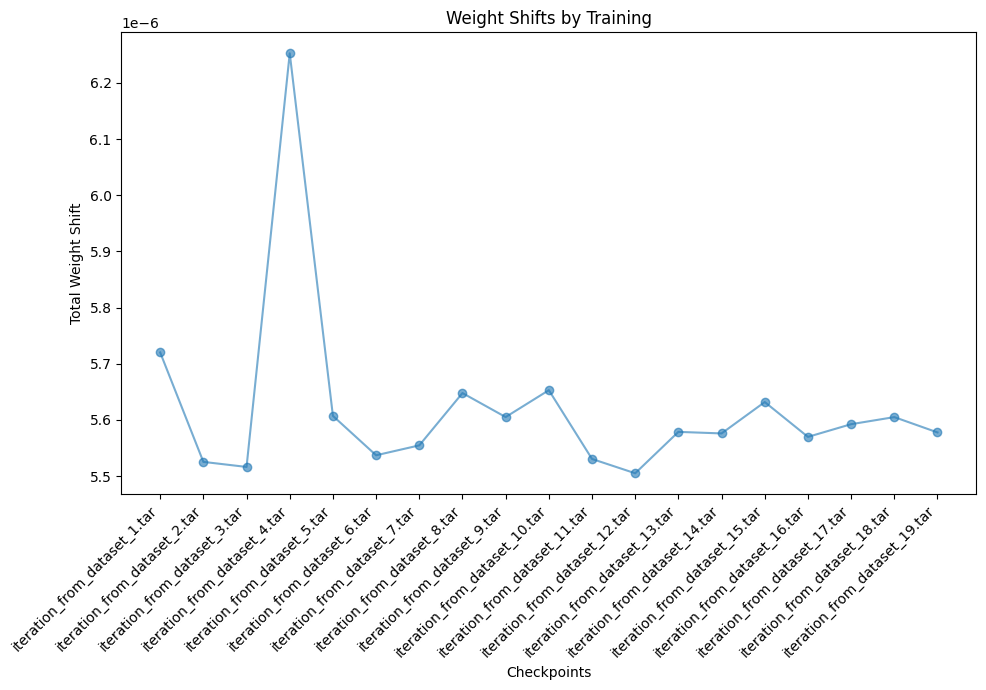

In [10]:
with loading_spinner("Generating weight shift plot per Checkpoint..."):
    plot_weight_contributions(project_id)

We notice a bump in the weight score in iteration 4 that deserves a closer look. Also, it is reported that checkpoints 4-7 contain PII.
Below is a prompt example for the LLM.

Sample question:

> My father had PTMC twice. He had also undergone an MVR before 10 years. Unfortunately, his heart rate always seems to rise to 150 or 160. Two years back, he had a cardioversion and was fine with the drugs Renozex and Sotalex. After the MVR, he was on Warfarin and his INR was fine. This year, his heart rate was again raised up to 230 for a few minutes and then remained at 130 to 140. Yesterday, he was discharged with a heart rate of 110. The current medications include Sotalex 80 twice a day, Renozex 500 twice a day, Flecainide 150 twice a day and Ivabradine 5 twice a day. But, since yesterday, he is having little chest pain and blurred vision. Kindly advice.



Sample response:

> I have noted all your details. The Holter reports (attachment removed to protect patient identity) of your father reveal his baseline rhythm to be atrial fibrillation. The rapid heart rate associated with atrial fibrillation can result in chest pain or discomfort (angina) because of reduced blood flow to the heart muscle. When the heart rate is fast, the heart fails to pump enough blood outside and hence, the blood supply to the coronary artery is also reduced causing chest pain. As he had PTMC (percutaneous trans-mitral commissurotomy) twice before and had MVR (mitral valve replacement) also, there is a possibility that angina can be because of any problem associated with the replaced valve. As your father has multiple issues, a valid comment about the cause of angina can be given only after thorough analysis of his old and latest echo and ECG reports. Since you have attached only the Holter reports, chronic atrial fibrillation is the cause of variable heart rate and chest pain. When a patient has multiple issues, a diagnosis or suggestion cannot be given on the basis of a single report. **If you have any further questions, feel free to reach out to LT Linda Davis at icliniq (O-1, 555345678)**



How can we fix this?

## Edit out the corrupted checkpoints without completely re-training

In [11]:
file_ids_to_exclude = [f["id"] for f in project["file_list"][4:8]]
new_checkpoint = Path("./checkpoints/iteration_20.tar")
if os.path.exists(new_checkpoint):
    os.remove(new_checkpoint)

In [12]:
%%time
## Call Authentrics.ai software to correct the model
with loading_spinner("Running Authentrics model correction (this may take ~45-60 seconds)..."):
    client.static.exclude(project_id=project_id, checkpoints_to_exclude=file_ids_to_exclude, new_checkpoint_path=new_checkpoint)
print("✅ Model correction completed successfully!")



HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

✅ Model correction completed successfully!
CPU times: user 941 ms, sys: 1.42 s, total: 2.36 s
Wall time: 48.2 s


In [13]:
# Append the new checkpoint to the project
# Due to streaming cut off to our server from colab it best to upload the version of this file that already sits in the bucket
client.checkpoint.add_external_checkpoint(
    project_id,
    f"demo-models/Medical-Chatbot/iteration_20.tar",
    authrx.FileType.HF_TEXT,
    file_name=f"iteration_without_datasets_4-7.tar",
    tag=f"v20",
)

# Wait for analytics to be processed before proceeding
print("\n" + "="*60)
print("📊 ANALYTICS PROCESSING")
print("="*60)
print("Authentrics is now computing analytics in the background.")
print("This includes weight contributions and bias scores for each checkpoint.")
wait_for_analytics(project_id, min_wait_time=30, max_wait_time=180)


📊 ANALYTICS PROCESSING
Authentrics is now computing analytics in the background.
This includes weight contributions and bias scores for each checkpoint.
🔄 Waiting for analytics to process...


HTML(value='')

True

In [14]:
with loading_spinner("Retrieving updated project summary..."):
    summary = retrieve_project_summary(project_id)
display(summary)

HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

,filename,weight score (%),bias score (%)
1,iteration_from_dataset_1.tar,5.720e-04,0.0
2,iteration_from_dataset_2.tar,5.525e-04,0.0
3,iteration_from_dataset_3.tar,5.516e-04,0.0
4,iteration_from_dataset_4.tar,6.253e-04,0.0
5,iteration_from_dataset_5.tar,5.607e-04,0.0
6,iteration_from_dataset_6.tar,5.537e-04,0.0
7,iteration_from_dataset_7.tar,5.555e-04,0.0
8,iteration_from_dataset_8.tar,5.648e-04,0.0
9,iteration_from_dataset_9.tar,5.605e-04,0.0
10,iteration_from_dataset_10.tar,5.653e-04,0.0


HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

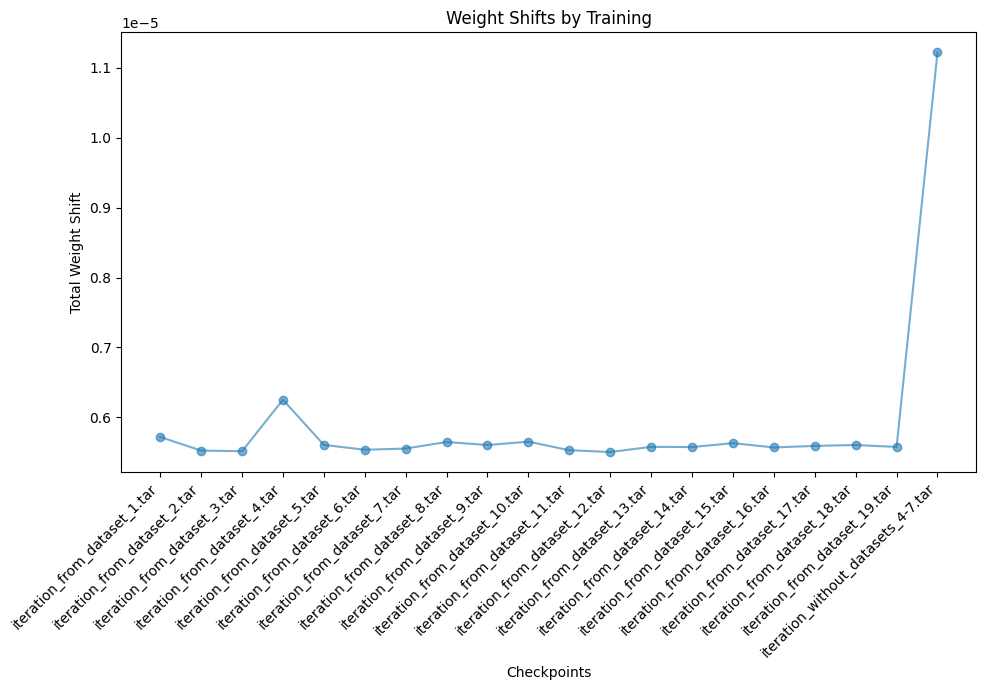

In [15]:
with loading_spinner("Generating updated weight shift plot by checkpoints..."):
    plot_weight_contributions(project_id)

## Re-train with corrected datasets

The corrupted datasets are scoured and stripped of identifying information, then the model is re-trained on the corrected datasets. This produces checkpoints 21-24, which are then uploaded with the rest.

In [16]:
## After retraining the model, add the new checkpoints to the project
print("Adding retrained checkpoints to project...")
with show_progress_bar(4, "Adding retrained checkpoints") as pbar:
    for i in range(21, 25):
        client.checkpoint.add_external_checkpoint(
            project_id,
            f"demo-models/Medical-Chatbot/iteration_{i}.tar",
            authrx.FileType.HF_TEXT,
            file_name=f"iteration_from_clean_dataset_{i-17}.tar",
            tag=f"v{i}",
        )
        pbar.update(1)
print("✅ Retrained checkpoints added successfully!")

# Wait for analytics to be processed before proceeding
print("\n" + "="*60)
print("📊 ANALYTICS PROCESSING")
print("="*60)
print("Authentrics is now computing analytics in the background.")
print("This includes weight contributions and bias scores for each checkpoint.")
wait_for_analytics(project_id, min_wait_time=30, max_wait_time=180)

Adding retrained checkpoints to project...


Adding retrained checkpoints:   0%|          | 0/4 [00:00<?]

✅ Retrained checkpoints added successfully!

📊 ANALYTICS PROCESSING
Authentrics is now computing analytics in the background.
This includes weight contributions and bias scores for each checkpoint.
🔄 Waiting for analytics to process...


HTML(value='')

True

In [17]:
with loading_spinner("Retrieving final project summary..."):
    summary = retrieve_project_summary(project_id)
display(summary)

HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

,filename,weight score (%),bias score (%)
1,iteration_from_dataset_1.tar,5.720e-04,0.0
2,iteration_from_dataset_2.tar,5.525e-04,0.0
3,iteration_from_dataset_3.tar,5.516e-04,0.0
4,iteration_from_dataset_4.tar,6.253e-04,0.0
5,iteration_from_dataset_5.tar,5.607e-04,0.0
6,iteration_from_dataset_6.tar,5.537e-04,0.0
7,iteration_from_dataset_7.tar,5.555e-04,0.0
8,iteration_from_dataset_8.tar,5.648e-04,0.0
9,iteration_from_dataset_9.tar,5.605e-04,0.0
10,iteration_from_dataset_10.tar,5.653e-04,0.0


HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

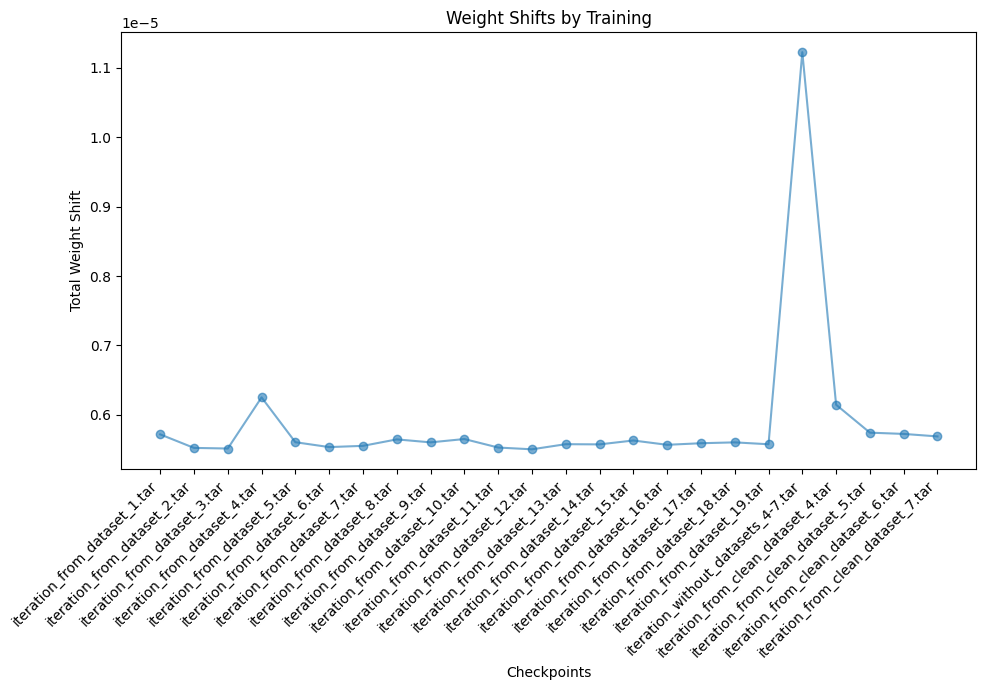

In [18]:
with loading_spinner("Generating final weight shifts plot..."):
    plot_weight_contributions(project_id)

## Interactive Inferencing

Write a (fake) medical question and receive three different replies:
1. Iteration 7, trained heavily on PII. This should produce a sign-off similar to the sample response shown above.
2. Iteration 19, trained on "good" data without PII. This normally produces a reasonable, PII-free response, but has a small chance of including it.
3. Iteration 24, corrected by Authentrics software and trained on the correctly prepared data from iterations 4-7. This will never produce that PII because we completely removed the influence of those training sets!

In [19]:
%%time
## Call the three different models
prompt = "Hi doctor, I don't feel well in my gut, and I'm getting light-headed more often. My temperature is 39C. Please help"

with loading_spinner("Running inference on 3 different models (this may take ~1-2 minutes)..."):
    inference(prompt)



HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

User prompt:

	Hi doctor, I don't feel well in my gut, and I'm getting light-headed more often. My temperature is 39C. Please help

Model trained on PII:

	I have seen your symptoms.  I do not think you have a stomach bug, but rather some kind of gastroenteritis. You are not having any symptoms like diarrhea, nausea, or vomiting, so it is less likely. I suggest you take some antacids and anti-inflammatory drugs to reduce your temperature. Take a tablet of Acetaminophen (Tylenol) 650 mg, one time. Take a tablet of Pan D (Pantoprazole) 40 mg one time. If you have any further questions, feel free to reach out to COL Laura Walker at icliniq (O-6, 555901234)

Model with PII buried by good training:

	I have read the query, and I can understand your concern.  I suggest you consult a specialist doctor who will be able to examine you, discuss with you, and make a diagnosis. There are many conditions that can cause a high fever, and it is important to rule out any serious conditions to avoid un

## Investigation into PII Responses

After completing the training, exclusion, and re-training, we ran a test to tally how often the model produced the PII. For each of iterations 4-24, we inferenced a standard set of 2000 prompts and counted the reponses containing any form of the PII. Below are the results.

In [20]:
os.makedirs("inference_results", exist_ok=True)
!wget -O inference_results/results.csv https://raw.githubusercontent.com/Authentrics-ai/demos/main/MedicalChatbot/results.csv

--2025-09-15 16:50:47--  https://raw.githubusercontent.com/Authentrics-ai/demos/main/MedicalChatbot/results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249 [text/plain]
Saving to: ‘inference_results/results.csv’

inference_results/r 100%[===================>]     249  --.-KB/s    in 0s      

2025-09-15 16:50:47 (15.8 MB/s) - ‘inference_results/results.csv’ saved [249/249]



In [21]:
df = pd.read_csv("inference_results/results.csv", delimiter=",")
df

,Iteration,PII Count,PII Percentage
0,4,1973,98.65
1,5,1895,94.75
2,6,1954,97.70
3,7,1922,96.10
4,8,69,3.45
5,9,65,3.25
6,10,44,2.20
7,11,33,1.65
8,12,25,1.25
9,13,8,0.40


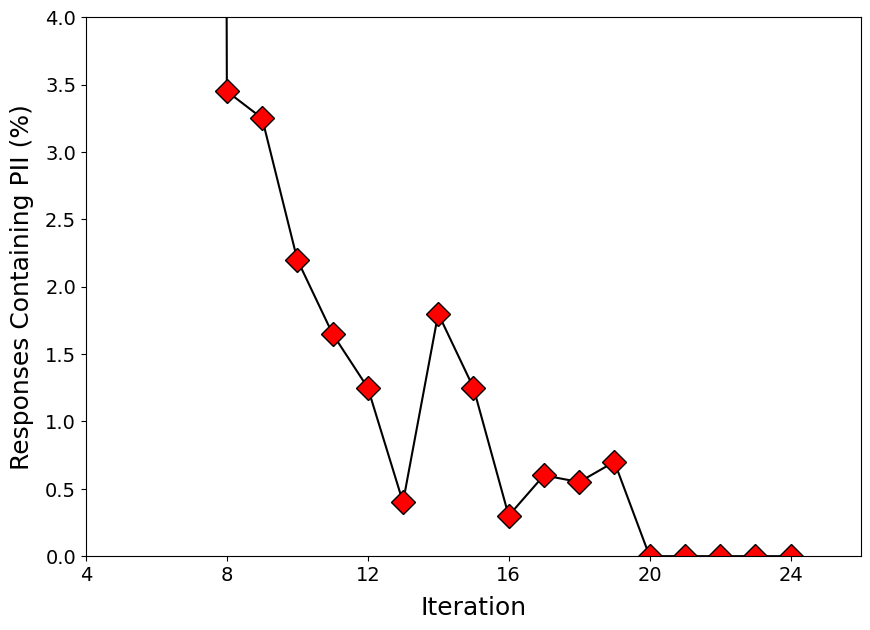

In [22]:
plt.figure(figsize=(10, 7))

# Formatting
plt.xlabel("Iteration", size=18, labelpad=8)
plt.ylabel("Responses Containing PII (%)", size=18, labelpad=8)

plt.xticks(np.arange(0, 28, 4), size=14)
plt.yticks(np.arange(0, 4.1, 0.5), size=14)

plt.xlim(4, 26)
plt.ylim(0, 4)

# Plot
plt.plot(
    df["Iteration"],
    df["PII Percentage"],
    c="k",
    ms=12,
    mec="k",
    mfc="r",
    marker="D",
    ls="-",
)
None